## Q-learning with ORF

**Algorithm: Q-learning with shallow function approximator**

---

Initialize replay memory D to capacity N

Initialize action-value function Q with random weights

**for** episode = 1 to M **do**

&nbsp;&nbsp;&nbsp;&nbsp; Initialize sequence $s_{1} = \{x_{1}\}$ and preprocessed sequence $\phi_{1} = \phi(s_{1})$

&nbsp;&nbsp;&nbsp;&nbsp; **for** t = 1 to T **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $a_{t} = \begin{cases} \max_{a}Q(\phi(s_{t}), a; \theta)&\text{with probability } 1-\epsilon \\ \text{random action }&\text{with probability } \epsilon \end{cases}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Execute action $a_{t}$ and observe reward $r_{t}$ and image $x_{t+1}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $s_{t+1}=s_{t}$, and preprocess $\phi_{t+1} = \phi(s_{t+1})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Store transition ($\phi_{t}, a_{t}, r_{t}, \phi_{t+1}$) in D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample random minibatch of transitions ($\phi_{j}, a_{j}, r_{j}, \phi_{j+1}$) from D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $y_{j} = \begin{cases} r_{j}&\text{for terminal } \phi_{j+1} \\ r_{j} + \gamma \max_{a'} Q(\phi_{j+1}, a'; \theta)&\text{for non-terminal } \phi_{j+1} \end{cases}$


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Fit the approximator with ($\phi_{j}$,  $y_{j}$)

&nbsp;&nbsp;&nbsp;&nbsp; **end for**

**end for**

---

s = state, 

a = current action, 

a' = action for the next state, 

$\theta$ = parameters for the function approximator, 

$Q(s,a;\theta)$: action-value function estimated by a function approximator



In [1]:
# Changes in v3: 
# Expand number of trees to maxTrees at episode = 100


In [1]:
import gym
import random
import pickle
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
# import os.path
# import copy
import numpy as np
import time
import datetime
import sys
from utils import mean, argmax
# import multiprocessing
# from cProfile import Profile

ModuleNotFoundError: No module named 'gym'

In [17]:
print(os.getcwd())

/mnt/c/Users/sonny/Gdrive/TreeQlearning/LunarLander


In [18]:
# # On Google Colab
# # # -------------------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive/')
# sys.path.insert(0, '/content/drive/My\ Drive/Colab\ Notebooks/')
# # # --------------------------------------------------------------------------
# !pip install box2d-py

In [19]:
# !pip install gym[Box2D]

In [20]:
# !python setup_DQN.py build_ext --inplace

In [21]:
# !cython -a ORF_cython.pyx
# !cython -a DQN.pyx
# %cd /content/drive/My\ Drive/ShallowQlearning/
# !python setup_ORF.py build_ext --inplace
# import pyximport
# pyximport.install()
# import ORF_cython as ORF
import ORF_py as ORF

In [22]:
class ORF_DQN: 
    
    def __init__(self, n_state, n_action, replay_size, ORFparams):
        self.n_action = n_action
        self.a_model = {} # to build RF for each action
        self.a_params = {a: ORFparams for a in range(n_action)}
        self.isFit = False
        self.maxTrees = ORFparams['maxTrees']
    
    def predict(self, s):            
        # s: (4,) array (for cartpole)
        # preds = []
        # for a in range(self.n_action):
        #     preds.append(self.a_model[a].predict(s))
        
        preds = [self.a_model[a].predict(s) for a in range(self.n_action)]
        # print(preds)
        return preds

    def gen_epsilon_greedy_policy(self, epsilon, n_action):
        
        def policy_function(state):
            # state: (4,) array
            ran = "_"
            q_values =[0.0, 0.0]
            if random.uniform(0,1) < epsilon:
                ran = "Random"
                return([random.randint(0, n_action - 1), ran, q_values])
            else:
                if self.isFit == True:
                    ran = "Model"
                    q_values = self.predict(state) # (1,2) array
                    # print(q_values)
                else: 
                    ran = "Random_notFit"
                    return([random.randint(0, n_action - 1), ran, q_values])
                    # print("passed random.randint")
            return([argmax(q_values), ran, q_values])# int
        
        return policy_function

    def replay(self, memory, replay_size, gamma, episode):

        if len(memory) == replay_size: # Build initial Forests
            
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                self.a_model[a] = ORF.ORF(self.a_params[a]) # Fit initial RFs for each action            

        if len(memory) >= replay_size: # When the memory size exceeds the replay_size, start updating the RFs            
            
            replay_data = random.sample(memory, replay_size) # replay_data consists of [state, action, next_state, reward, is_done]
            for state, action, next_state, reward, is_done in replay_data:
                
                q_values = self.predict(state) # (, n_actions)
                q_values[action] = reward + gamma * max(self.predict(next_state)) if is_done == False else -100*reward
                
                # Update the RF for the action taken
                xrng = ORF.dataRange([v[0] for v in replay_data if v[1] == action])
                self.a_model[action].update(state, q_values[action], xrng)    
            self.isFit = True
               
        if episode == 100: # expand the number of trees at episode 100            
            # expandForest(memory)
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                lenFor = len(self.a_model[a].forest)
                for i in range(lenFor+1, self.maxTrees):
                    self.a_model[a].forest[i] = ORF.ORT(self.a_params[a]) # build new empty trees

def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=0.95):
    
    for episode in tqdm(range(n_episode)):
        policy = estimator.gen_epsilon_greedy_policy(epsilon, n_action)
        state = env.reset()
        is_done = False
        i = 0
        while not is_done:
            action, ran, pred = policy(state) # integer
            next_state, reward, is_done, _ = env.step(action)
            i += 1
            # next_state: 4x1 array (for cartpole)
            # reward: integer
            # is_done: bool (True/False)

            total_reward_episode[episode] += reward
            
            ## Modified rewards for LunarLander?

            ep[episode].append((i, state, ran, action))
            # memory.append((state, action, next_state, modified_reward, is_done))
            memory.append((state, action, next_state, reward, is_done))
            
            if is_done:
                break
            estimator.replay(memory, replay_size, gamma, episode)
            state = next_state
        epsilon = max([epsilon * epsilon_decay, 0.01])
        # print(epsilon)

In [23]:
# Initialization
env = gym.envs.make("LunarLander-v2")
# env=gym.envs.make("CartPole-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
memory = deque(maxlen=10000)
n_episode = 50
replay_size = 32

ORFparams = {'minSamples': replay_size*2, 'minGain': 0.1, 'xrng': None, 'maxDepth': 15, 'numTrees': 5, 'maxTrees': 30, 'gamma'=0.05} 

dqn = ORF_DQN(n_state, n_action, replay_size, ORFparams) 

total_reward_episode = np.zeros(n_episode)

ep = {i: [] for i in range(n_episode)}

QLparams = {'gamma' : 1.0, 'epsilon' : 0.5, 'epsilon_decay' : 0.99}

In [24]:
# Run alg

start = time.time()

q_learning(env, dqn, n_episode, replay_size, gamma=QLparams['gamma'], epsilon=QLparams['epsilon'], epsilon_decay=QLparams['epsilon_decay']) # runs the alg

end = time.time()

duration = int(end - start)

print("learning duration =", duration, " seconds")
print("mean reward = ", np.mean(total_reward_episode))
print("max reward = ", max(total_reward_episode))



  2%|▏         | 1/50 [00:19<15:41, 19.21s/it]


KeyboardInterrupt: 

In [ ]:
# backup_file_name = "ORF_LunarLander_" + time.strftime("%y%m%d") + "_1"
backup_file_name = "ORF_LunarLander_" + time.strftime("%y%m%d") + "_1"
img_file = backup_file_name + ".jpg"
plt.plot(total_reward_episode)
plt.title("(ORF) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.hlines(195, xmin=0, xmax=n_episode, linestyles="dotted", colors="gray")
plt.show()
plt.savefig(fname = img_file)

In [ ]:
# To back-up the work
backup_file = backup_file_name + ".p"
backup_check = os.path.isfile(backup_file)

myEnv = dict()
myEnv["t_r_e"] = result
myEnv["duration"] = duration
myEnv["episode_details"] = ep
myEnv["ORFparams"] = ORFparams
myEnv["QLparams"] = QLparams
# myEnv["ORF_params"] = params

with open(backup_file, "wb") as file:
    pickle.dump(myEnv, file)

In [ ]:
# About LunarLander
"""
Rocket trajectory optimization is a classic topic in Optimal Control.
According to Pontryagin's maximum principle it's optimal to fire engine full throttle or
turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).
The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.
Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.
Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.
Solved is 200 points.

Landing outside the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt. Please see the source code for details.
To see a heuristic landing, run:
python gym/envs/box2d/lunar_lander.py
To play yourself, run:
python examples/agents/keyboard_agent.py LunarLander-v2
Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

observation_space = (x coord, y coord, x velocity, y velocity, lander angle, angular velocity, right-leg grounded, left-leg grounded)
action_space = do nothing(0), fire left engine(1), fire mian engine(2), fire right engine(3)
"""


In [ ]:
# import pstats
# stats = pstats.Stats("profile_200913.pfl")
# stats.strip_dirs()
# stats.sort_stats('cumulative')
# stats.print_stats()

dict_keys(['ep', 'ORFparams', 'QLparams', 'tre'])


Text(0.5, 1.0, 'mean total reward per 10 episodes')

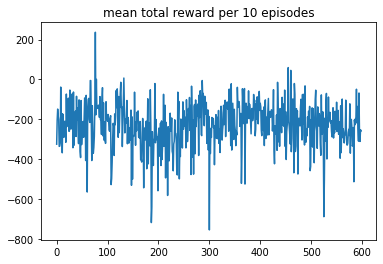

In [6]:
import pickle
import matplotlib.pyplot as plt

with open("lunar_noModifiedReward201129_1.p", "rb") as file:
    myEnv = pickle.load(file)

print(myEnv.keys())
total_reward_episode = myEnv["tre"]
ep = myEnv["ep"]
n_episode = len(total_reward_episode)

per_h = [0] * int(n_episode/100)
j = list(range(1, int(n_episode), 100))
for i in range(1,len(j)):
    aa = total_reward_episode[j[(i-1)]: j[(i)]]
    per_h[(i-1)] = sum(aa)/len(aa)

plt.plot(total_reward_episode[1400:1999])
plt.title("mean total reward per 10 episodes")

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.plot(c_frame["mean"])
# plt.title("mean cumulative reward (10 times)")

# plt.subplot(1,2,2)
# plt.plot(per_h)
# plt.title("mean total reward per 10 episodes")



In [7]:
total_reward_episode.index(max(total_reward_episode))

1476

In [2]:
import gym
env2 = gym.envs.make("LunarLander-v2")
env2.reset()

array([ 0.00300293,  1.4014068 ,  0.30415055, -0.4228136 , -0.00347287,
       -0.06889462,  0.        ,  0.        ], dtype=float32)

In [6]:
a = 1.

In [11]:
b = 1.00

str(b)[::-1].find(".")

1